In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

#基础方法1：逐像素matching(No block?)
def compute_disparity_map(img_left, img_right, ndisp):
    """从左图和右图计算视差图，使用逐像素匹配。"""
    height, width = img_left.shape
    print(f'image height:{height} width:{width}')
    img_disp = np.zeros((height, width), dtype=np.uint8)

    for j in tqdm(range(height), desc="Computing Disparity"):
        for i in range(width):
            min_cost = float('inf')
            best_match = 0

            # 在右图中查找对应点
            for d in range(max(0, i - ndisp), min(width, i + 1)):
                cost = abs(int(img_left[j, i]) - int(img_right[j, d]))

                if cost < min_cost:
                    min_cost = cost
                    best_match = d

            # 计算视差
            disparity = abs(i - best_match)
            img_disp[j, i] = min(disparity * (255 // ndisp), 255)

    img_disp = cv2.normalize(img_disp, None, 0, 255, cv2.NORM_MINMAX)
    return img_disp

def preprocess_he(image):
    """对图像进行预处理以提高视差计算效果。"""
    equalized_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    y_channel, u_channel, v_channel = cv2.split(equalized_image)
    y_channel_equalized = cv2.equalizeHist(y_channel)
    equalized_image = cv2.merge((y_channel_equalized, u_channel, v_channel))
    equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_YUV2BGR)

    #blurred_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)
    return cv2.cvtColor(equalized_image, cv2.COLOR_BGR2GRAY)

def show_images(img_left, img_right, img_disp, title):
    """显示图像的辅助函数。"""
    plt.figure(figsize=(15, 5))
    plt.title(title)
    plt.imshow(img_disp, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Disparity Value')
    plt.axis('off')
    plt.show()

# 基础方法2：block matching - OPENCV实现
def compute_opencv_disparity(img_left, img_right, ndisp,blockSize):
    """使用 OpenCV 的 StereoBM 计算视差图，并进行边界延拓。"""
    img_left_extended = cv2.copyMakeBorder(img_left, 0, 0, ndisp, 0, cv2.BORDER_REPLICATE)
    img_right_extended = cv2.copyMakeBorder(img_right, 0, 0, ndisp, 0, cv2.BORDER_REPLICATE)

    stereo = cv2.StereoBM_create(numDisparities=ndisp, blockSize=blockSize)
    disparity = stereo.compute(img_left_extended, img_right_extended).astype(np.float32) / 16.0

    disparity = disparity[:, ndisp:]  # 截取有效视差区域
    return cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# 提高方法1: semi-global block matching - OPENCV实现
def compute_stereosgbm_disparity(img_left, img_right, ndisp,blockSize):
    """使用 OpenCV 的 StereoSGBM 计算视差图，并进行边界延拓。"""
    img_left_extended = cv2.copyMakeBorder(img_left, 0, 0, ndisp, 0, cv2.BORDER_REPLICATE)
    img_right_extended = cv2.copyMakeBorder(img_right, 0, 0, ndisp, 0, cv2.BORDER_REPLICATE)

    stereo_sgbm = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=ndisp,
        blockSize=blockSize,
        P1=8 * 3 * blockSize * blockSize,
        P2=32 * 3 * blockSize * blockSize,
        disp12MaxDiff=1,
        uniquenessRatio=15,
        speckleWindowSize=0,
        speckleRange=0,
    )
    disparity = stereo_sgbm.compute(img_left_extended, img_right_extended).astype(np.float32) / 16.0

    disparity = disparity[:, ndisp:]  # 截取有效视差区域
    return cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)








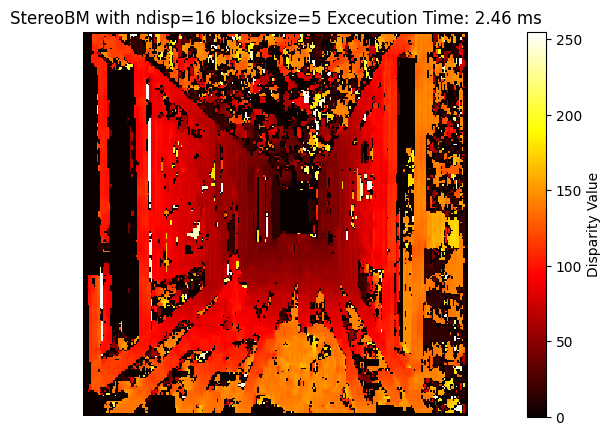

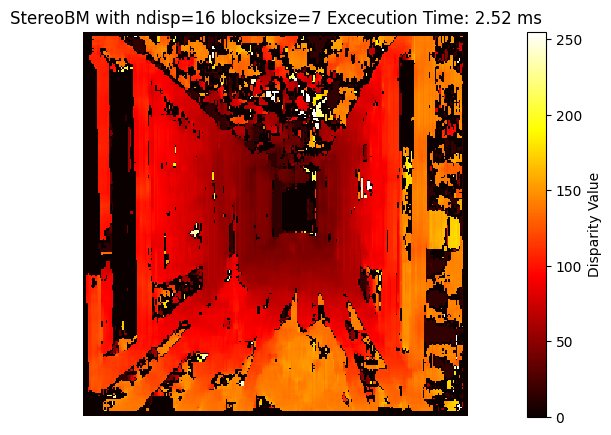

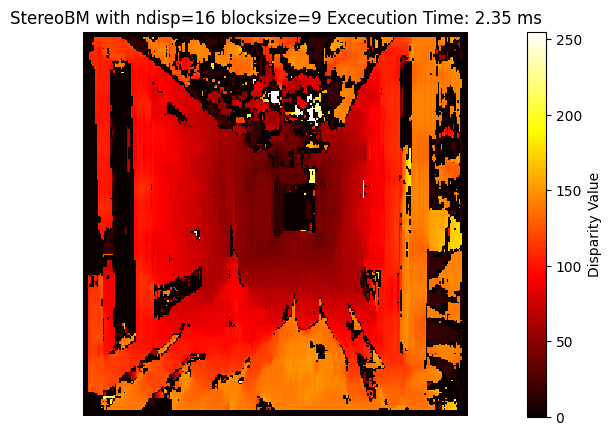

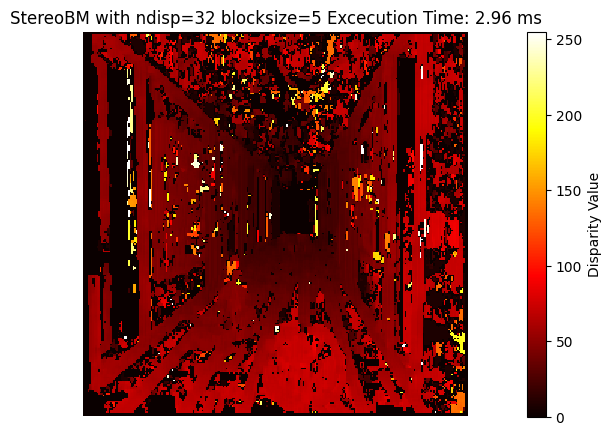

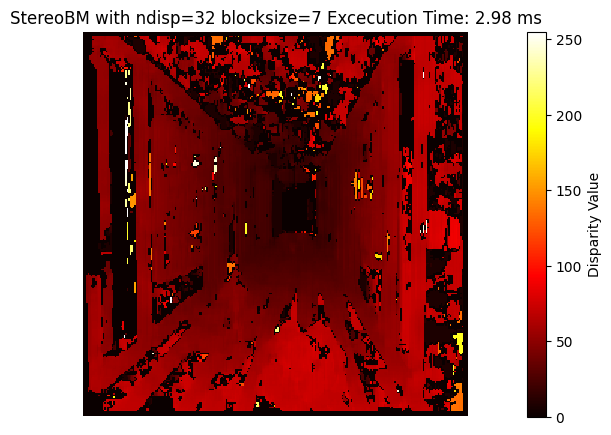

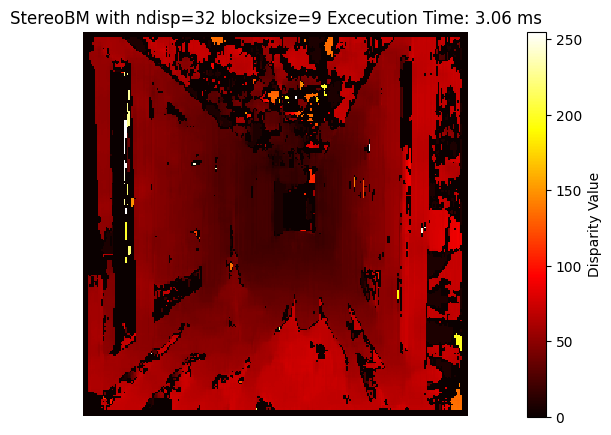

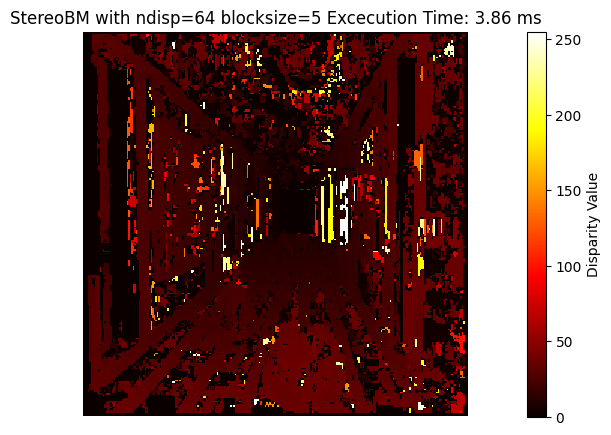

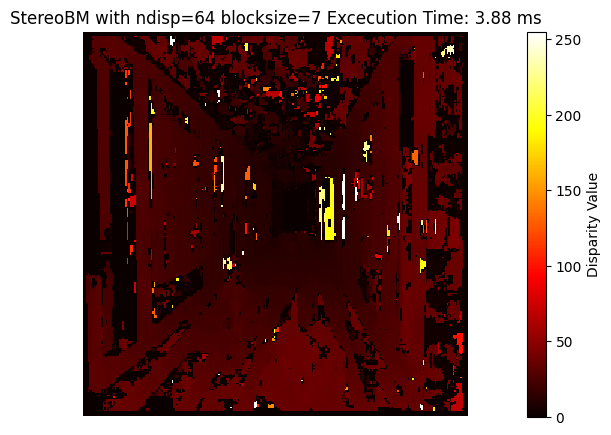

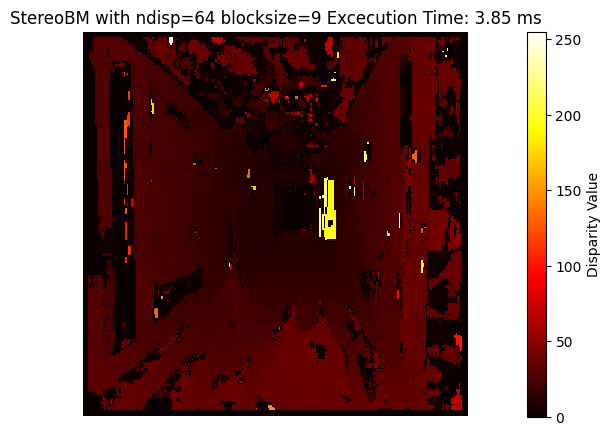

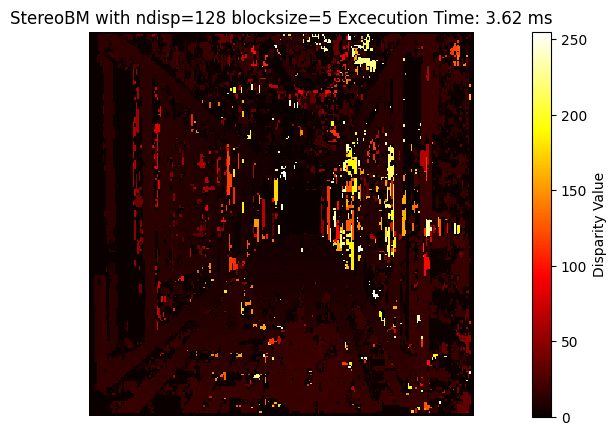

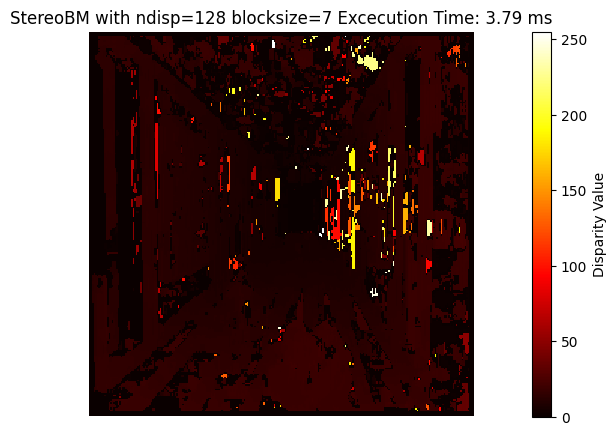

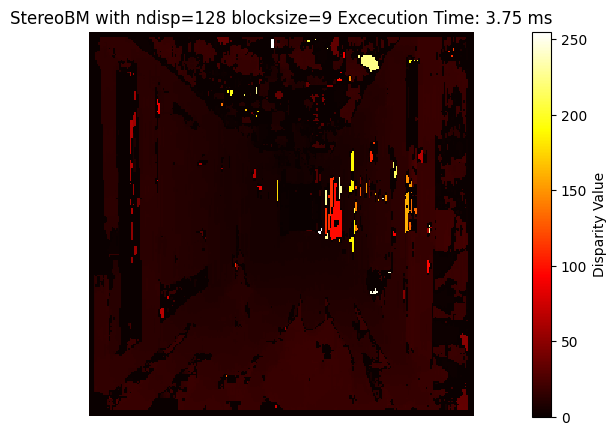

In [12]:
# Paramter tuning
def main(left_path, right_path):
    """主函数：加载图像，计算视差图，并显示结果。"""
    start_time = time.time()

    img_left = cv2.imread(left_path)
    img_right = cv2.imread(right_path)
    for ndisp in [16, 32, 64, 128]:
        for block_size in [5, 7, 9]:
            # Use StereoBM as example
            st = time.time()
            img_disp_opencv = compute_opencv_disparity(cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY),
                                                        cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY), ndisp,block_size)
            ed = time.time()
            t = (ed-st)*1000.0
            show_images(img_left, img_right, img_disp_opencv, f"StereoBM with ndisp={ndisp} blocksize={block_size} Excecution Time: {t:.2f} ms")

if __name__ == "__main__":
    main('Assignment02 Disparity and Depth/corridorl.jpg', 'Assignment02 Disparity and Depth/corridorr.jpg')

image height:256 width:256


Computing Disparity: 100%|██████████| 256/256 [00:00<00:00, 682.50it/s]


image height:256 width:256


Computing Disparity: 100%|██████████| 256/256 [00:00<00:00, 256.70it/s]


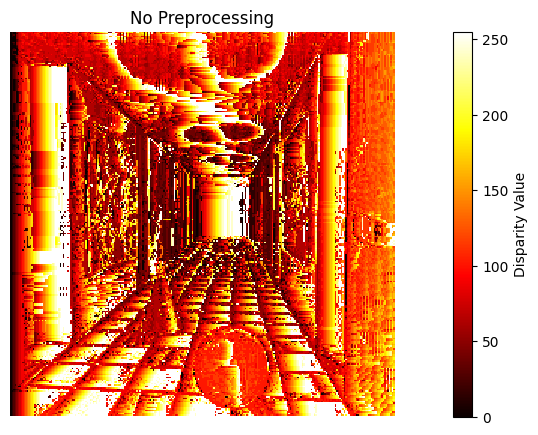

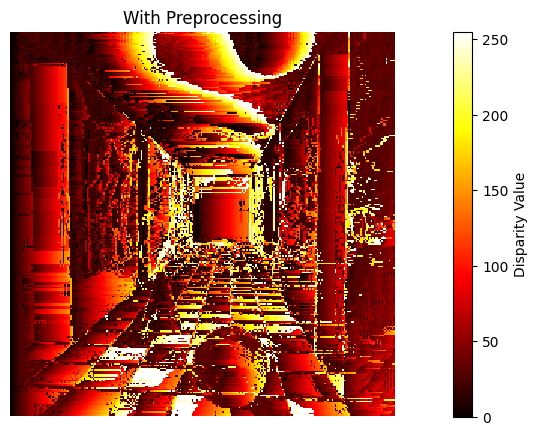

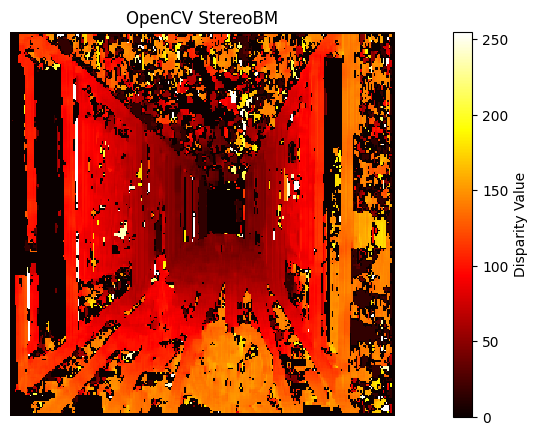

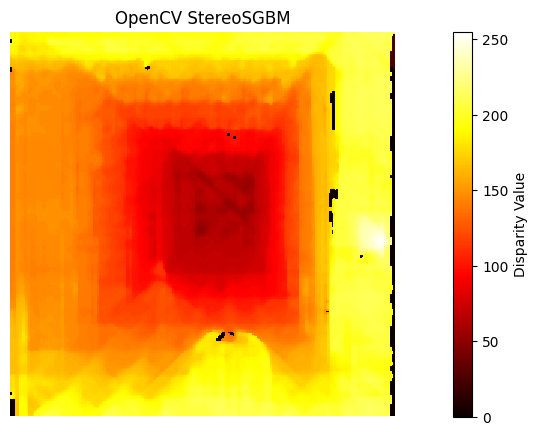

Execution Time: 1.79 seconds


In [4]:
def main(left_path, right_path):
    """主函数：加载图像，计算视差图，并显示结果。"""
    start_time = time.time()

    img_left = cv2.imread(left_path)
    img_right = cv2.imread(right_path)

    # 处理未经预处理的图像
    img_disp_no_preprocessing = compute_disparity_map(
        cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY),
        cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY),
        20
    )

    # 处理经过预处理的图像
    img_left_preprocessed = preprocess_he(img_left)
    img_right_preprocessed = preprocess_he(img_right)

    img_disp_with_preprocessing = compute_disparity_map(img_left_preprocessed, img_right_preprocessed, 64)

    # 处理 OpenCV 的 StereoBM
    img_disp_opencv = compute_opencv_disparity(cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY),
                                                 cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY), 16,5)

    # 处理 OpenCV 的 StereoSGBM
    img_disp_stereosgbm = compute_stereosgbm_disparity(cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY),
                                                         cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY), 16,5)

    # 显示图像
    show_images(img_left, img_right, img_disp_no_preprocessing, "No Preprocessing")
    show_images(img_left_preprocessed, img_right_preprocessed, img_disp_with_preprocessing, "With Preprocessing")
    show_images(img_left, img_right, img_disp_opencv, "OpenCV StereoBM")
    show_images(img_left, img_right, img_disp_stereosgbm, "OpenCV StereoSGBM")

    duration = time.time() - start_time
    print(f"Execution Time: {duration:.2f} seconds")

if __name__ == "__main__":
    main('Assignment02 Disparity and Depth/corridorl.jpg', 'Assignment02 Disparity and Depth/corridorr.jpg')

##  Block matching custom implementation
### aggregation methods: sad, ssd, ncc





In [116]:
### 基础方法2 block matching， 自己实现
import numpy as np

def NCC(left, right):
    diff_l = left - np.mean(left)
    diff_r = right - np.mean(right)
    NCC_up = np.sum(np.sum(diff_l * diff_r))
    NCC_down = np.sqrt(np.sum(np.sum(diff_l**2)) * np.sum(np.sum(diff_r**2)))
    return (NCC_up / NCC_down)


def SobelFilter(img):
    h, w = img.shape
    processed = np.zeros((h, w))

    table_x = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]))
    table_y = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]))

    for y in range(2, w - 2):
        for x in range(2, h - 2):
            cx, cy = 0, 0
            for offset_y in range(0, 3):
                for offset_x in range(0, 3):
                    pix = img[x + offset_x - 1, y + offset_y - 1]
                    if offset_x != 1:
                        cx += pix * table_x[offset_x, offset_y]
                    if offset_y != 1:
                        cy += pix * table_y[offset_x, offset_y]
            out_pix = np.math.sqrt(cx**2 + cy**2)
            processed[x, y] = out_pix if out_pix > 0 else 0
    np.putmask(processed, processed > 255, 255)
    return processed


def compute_disparity_map_bm(left_img,
                             right_img,
                             block_size=5,
                             ndisp=64,# same as ndisp
                             match_method='sad', #[sad,ssd,ncc, weight ]
                             direction='left', # left to right or right to left, note searching direction is different
                             gamma=10.0, #hyper parameter for adaptive weight, lower is more weight-controlled,
                             ):

    # Get dimensions of the images
    height, width = left_img.shape

    # Initialize the disparity map
    disparity_matrix = np.zeros((height, width), np.float32)

    # Half of the block size to use for padding
    half_block = block_size // 2

    # Pad the images to handle border blocks
    left_padded = cv2.copyMakeBorder(left_img, half_block, half_block, half_block, half_block, cv2.BORDER_CONSTANT, 0)
    right_padded = cv2.copyMakeBorder(right_img, half_block, half_block, half_block, half_block, cv2.BORDER_CONSTANT, 0)



    # Loop over each pixel in the left image
    for y in tqdm(range(half_block, height - half_block), desc="Computing Disparity"):
        for x in range(half_block, width - half_block):
            # Define the reference block from the left image
            left_block = left_padded[y - half_block : y + half_block, x - half_block : x + half_block ]
            weights = np.exp(-np.abs(left_block - left_block[half_block, half_block]) / gamma)
            if match_method=='ncc':
                min_value = 0
            else:
                min_value = float('inf')

            best_disparity = 0
            # Check within the disparity range in the right image
            edge_value = x-half_block-1 if direction=='left' else width - x - half_block
            for d in range(0,min(ndisp,edge_value)):
                #if x - d - half_block < 0:
                #    break  # Out of bounds on the left side of the image

                # Extract the block from the right image
                if direction=='left':
                    right_block = right_padded[y - half_block : y + half_block, x - d - half_block : x - d + half_block]
                else:
                    right_block = right_padded[y - half_block : y + half_block, x + d - half_block : x + d + half_block]

                # Compute the Sum of Absolute Differences (SAD) between blocks
                if match_method=='weight':
                    diff = np.abs(left_block - right_block)
                    weighted_cost = np.sum(weights * diff)
                    if weighted_cost < min_value:
                        min_value = weighted_cost
                        best_disparity = d

                elif match_method=='sad':
                    sad = np.sum(np.sum(np.abs(left_block - right_block)))
                    # Find the best match with minimum SAD
                    if sad < min_value:
                        min_value = sad
                        best_disparity = d

                elif match_method=='ssd':
                    ssd = (np.sum(np.sum(np.abs(left_block - right_block)**2)))
                    # Find the best match with minimum SSD
                    if ssd < min_value:
                        min_value = ssd
                        best_disparity = d
                elif match_method=='ncc':
                    # Find the best match with max NCCC
                    ncc = NCC(left_block, right_block)
                    if ncc > min_value:
                        min_value = ncc
                        best_disparity = d

            # Assign the disparity to the disparity map
            disparity_matrix[y - half_block, x - half_block] = best_disparity

    # Normalize the disparity map for visualization
    disp_map_normalized = cv2.normalize(disparity_matrix, None, 0, 255, cv2.NORM_MINMAX)
    return disp_map_normalized.astype(np.uint8),disparity_matrix

In [121]:
def compute_disparity_left_right_consistency_check(left_map, right_map, block_size=15,ndisp=64,thre=1.0):

    # Initialize the consistency mask
    h, w = left_map.shape
    consistency_mask = np.zeros_like(left_map, dtype=np.uint8)

    # Perform the left-right consistency check
    threshold = 1.0  # Acceptable threshold for disparity difference
    for y in range(h):
        for x in range(w):
            # Disparity value at the current pixel (x, y) in left disparity map
            d_left = left_map[y, x]
            if d_left > 0:  # Valid disparity in the left image
                # Corresponding x-coordinate in the right image
                x_right = int(x - d_left)
                if 0 <= x_right < w:  # Ensure x_right is within image bounds
                    d_right = right_map[y, x_right]
                    # Check consistency: |d_left - d_right| < threshold
                    if abs(d_left - d_right) < thre:
                        consistency_mask[y, x] = 255  # Mark as consistent
                    else:
                        consistency_mask[y, x] = 0   # Mark as inconsistent
                else:
                    consistency_mask[y, x] = 0       # Out of bounds in the right image
            else:
                consistency_mask[y, x] = 0           # Invalid disparity in left image

    # Apply the consistency mask to the disparity map
    disparity_left_consistent = np.where(consistency_mask == 255, left_map, 0)
    disp_map_normalized = cv2.normalize(disparity_left_consistent, None, 0, 255, cv2.NORM_MINMAX)
    return disp_map_normalized, consistency_mask


def preprocess(img, method=None,blur_size=0):
  print(img.shape)
  if method=='he':
    return preprocess_he(img)
  else:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      if method=='sobel':
          img= SobelFilter(img)
      if blur_size>0:
          img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
      return img


### Improved: Different Preprocess

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


<ipython-input-78-0672a522fd52>:29: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  out_pix = np.math.sqrt(cx**2 + cy**2)


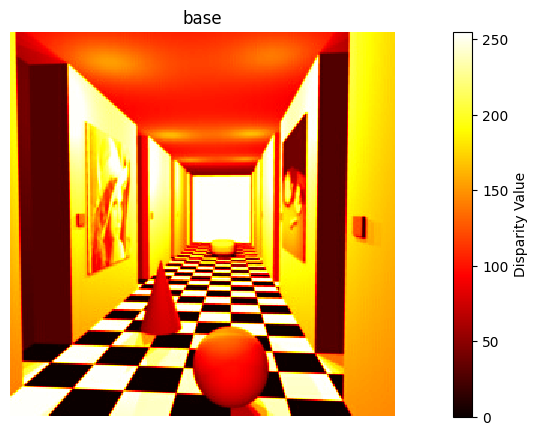

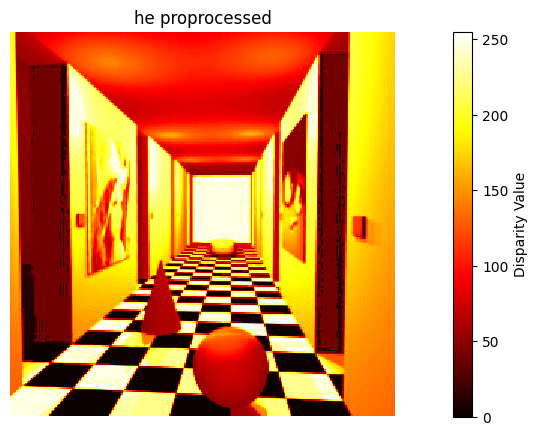

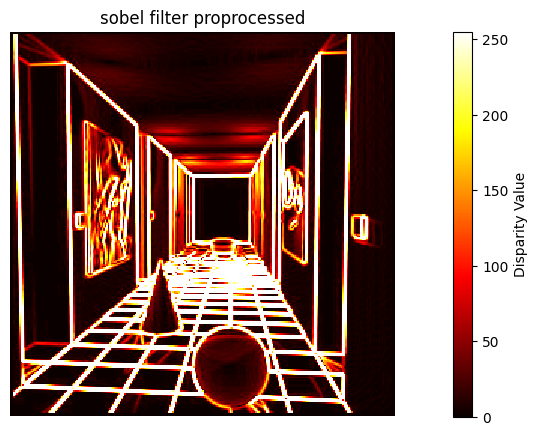

convert to greyscale


Computing Disparity: 100%|██████████| 252/252 [00:18<00:00, 13.99it/s]


convert to greyscale


Computing Disparity: 100%|██████████| 252/252 [00:13<00:00, 18.35it/s]


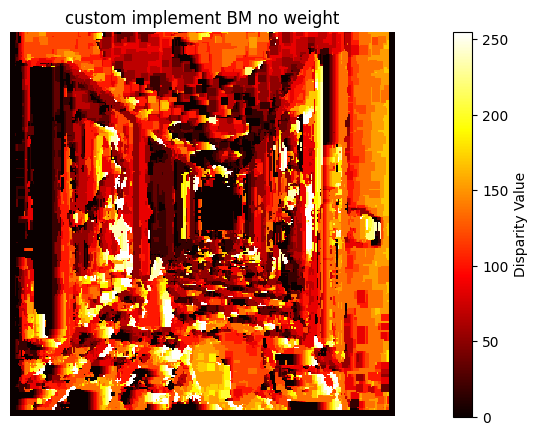

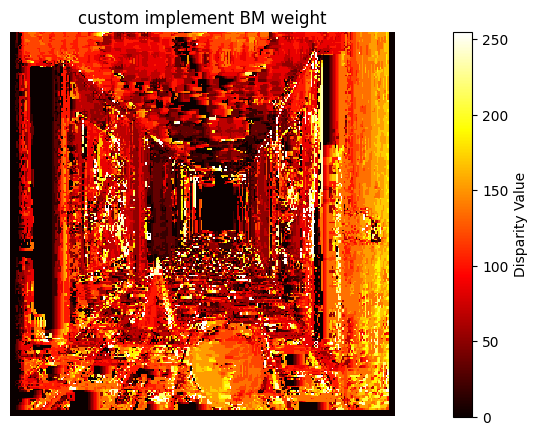

In [101]:
# Load your stereo images
left_img = cv2.imread('/content/corridorl.jpg')
right_img = cv2.imread('/content/corridorr.jpg')

left_img_base = preprocess(left_img) # default to change to grayscale
left_img_he = preprocess(left_img, method='he',blur_size=5)
left_img_sobel = preprocess(left_img, method='sobel')

show_images(left_img, right_img, left_img_base, 'base')
show_images(left_img, right_img, left_img_he, 'he proprocessed and blurred')
show_images(left_img, right_img, left_img_sobel, 'sobel filter proprocessed')



### Improved: different matching method

(256, 256, 3)
(256, 256, 3)


Computing Disparity: 100%|██████████| 252/252 [00:11<00:00, 21.62it/s]


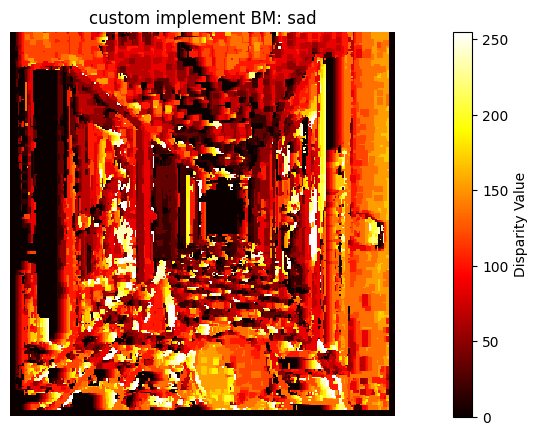

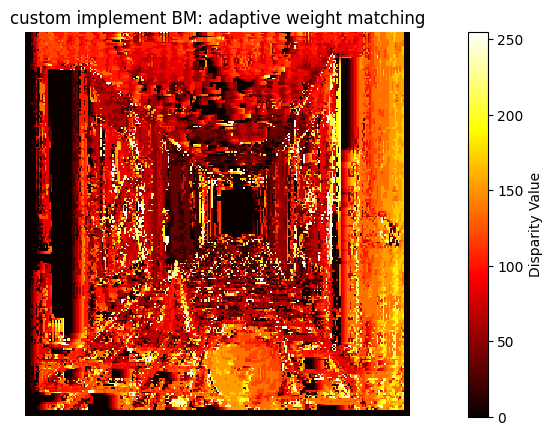

In [118]:
#TODO: different types of match method: sad, ssd, ncc, weight (Adaptive Weight Matching)
#example: sad vs weight
left_img = cv2.imread('/content/corridorl.jpg')
right_img = cv2.imread('/content/corridorr.jpg')
left_img = preprocess(left_img) # default to change to grayscale
right_img = preprocess(right_img)
disparity_map, _ = compute_disparity_map_bm(left_img, right_img,block_size=5, ndisp=16, match_method='sad')
disparity_map2, _ = compute_disparity_map_bm(left_img, right_img,block_size=5, ndisp=16, match_method='weight', gamma=5.0)
#disparity_map3, _ = compute_disparity_map_bm(left_img, right_img,block_size=5, ndisp=16, match_method='ssd')
#disparity_map4, _ = compute_disparity_map_bm(left_img, right_img,block_size=5, ndisp=16, match_method='ncc')

show_images(left_img, right_img, disparity_map, 'custom implement BM: sad')
show_images(left_img, right_img, disparity_map2, 'custom implement BM: adaptive weight matching')

#

### Improved: left-right consistency check and post process median filter

(256, 256, 3)
(256, 256, 3)


Computing Disparity: 100%|██████████| 252/252 [00:16<00:00, 15.13it/s]


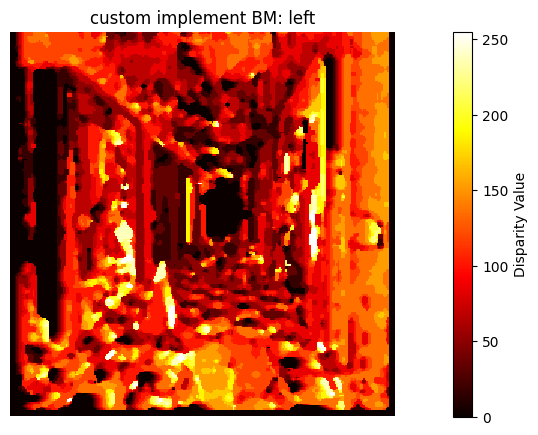

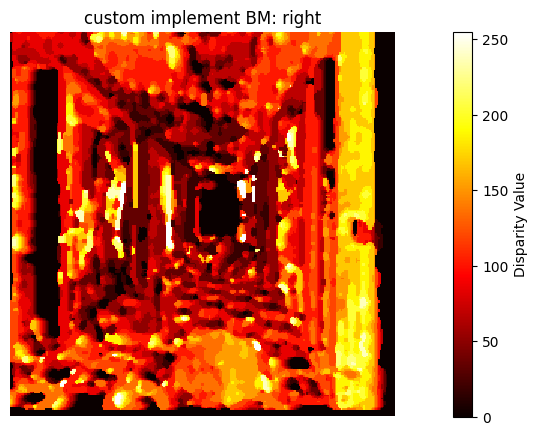

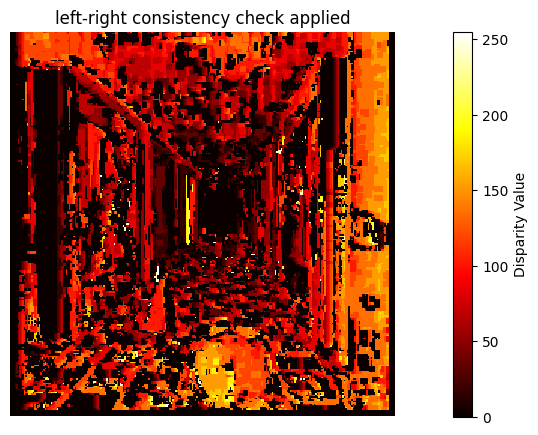

In [124]:
left_img = cv2.imread('/content/corridorl.jpg')
right_img = cv2.imread('/content/corridorr.jpg')
left_img = preprocess(left_img) # default to change to grayscale
right_img = preprocess(right_img)
disparity_map,unormalize_left = compute_disparity_map_bm(left_img, right_img,block_size=5, ndisp=16, match_method='sad', direction='left')
disparity_map2,unormalize_right = compute_disparity_map_bm(right_img, left_img,block_size=5, ndisp=16, match_method='sad', direction='right')
# Apply median filtering after map calculation
disparity_map = cv2.medianBlur(disparity_map, 5)
disparity_map2 = cv2.medianBlur(disparity_map2, 5)

show_images(left_img, right_img, disparity_map, 'custom implement BM: left')
show_images(left_img, right_img, disparity_map2, 'custom implement BM: right')

consistent_checked_left,_ = compute_disparity_left_right_consistency_check(unormalize_left,unormalize_right,block_size=5, ndisp=16,thre=5.0)
show_images(left_img, right_img, consistent_checked_left, 'left-right consistency check applied')
